In [1]:
import os, sys, torch, argparse, re, mat73, scipy, time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurokit2 as nk
import peakutils
from copy import deepcopy
import pandas as pd
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from LibMTL.config import LibMTL_args, prepare_args
from LibMTL.utils import set_random_seed, set_device
from LibMTL.model import resnet_dilated
from LibMTL import Trainer
from Projects.radarODE_plus.utils.utils import shapeMetric, shapeLoss, ppiMetric, ppiLoss, anchorMetric, anchorLoss
from Projects.radarODE_plus.nets.PPI_decoder import PPI_decoder
from Projects.radarODE_plus.nets.anchor_decoder import anchor_decoder
from Projects.radarODE_plus.nets.model import backbone, shapeDecoder, ECGFormer
from config import prepare_args
from Projects.radarODE_plus.spectrum_dataset import normal_ecg_torch_01
from spectrum_dataset import dataset_concat
%matplotlib inline
data_org_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_org/"
rcg_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_rcg/test"
sst_root = '/home/zhangyuanyuan/Dataset/data_MMECG/30Hz_half/'
interval_root = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/'
pred_all_root = '/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/'
params, unknown = LibMTL_args.parse_known_args()
params.mode = 'test'
params.gpu_id = '3'
set_device(params.gpu_id)

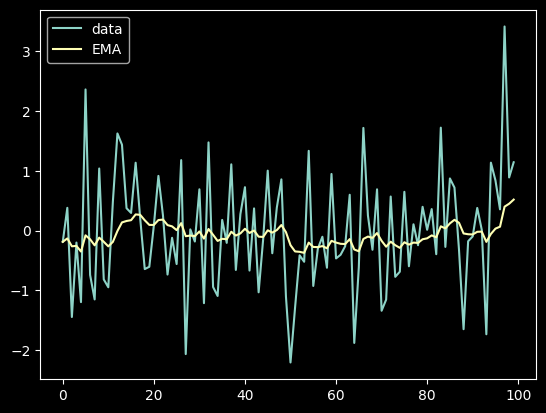

In [2]:
# write a example of exponential moving average
def EMA(data, alpha=0.1):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append((1-alpha)*ema[-1] + alpha*data[i])
    return ema
# plot the example
data = np.random.randn(100)
plt.plot(data, label='data')
plt.plot(EMA(data), label='EMA')
plt.legend()

In [168]:
def combine_close_peaks(peaks, ther):
    """
    combine the peaks that are too close to each other
    """
    distance = np.diff(peaks)
    peaks_new = np.array([])
    temp =[]
    for i in range(0, len(peaks)-1):
        temp.append(peaks[i])
        if distance[i]<ther:
            continue
        else:
            peaks_new = np.append(peaks_new, np.median(temp))
            temp = []
    return peaks_new
def offset_calcu(R_peaks, detected, mdr_ther=30):
    offset = []
    missed_peak = np.array([])
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            offset.append((detected-peak)[np.argmin(temp_error)])
        else:
            missed_peak = np.append(missed_peak, peak)
    return np.median(offset), missed_peak
def metric_anchor(R_peaks, detected, mdr_ther=10):
    error_sec, missed = 0, 0
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            error_sec+=np.min(temp_error)/200
        else:
            missed+=1
    return error_sec/(len(R_peaks)-missed/len(R_peaks))
def non_maximum_suppression_1d(signal, threshold=0.7):
    """
    Apply Non-Maximum Suppression for a 1D signal.

    Parameters:
    - signal: np.ndarray, the input 1D signal.
    - threshold: float, the relative threshold to consider for suppression in the range [0, 1].

    Returns:
    - suppressed_signal: np.ndarray, the signal after applying NMS.
    """ 
    # Find the indices of local maxima
    local_maxima = np.r_[True, signal[1:] > signal[:-1]] & np.r_[signal[:-1] > signal[1:], True]
    
    # Initialize the suppressed signal with zeros
    suppressed_signal = np.zeros_like(signal)
    
    # Apply threshold to filter out weaker maxima
    max_value = np.max(signal)
    significant_maxima = local_maxima & (signal > (max_value * threshold))
    
    # Retain only the significant maxima in the suppressed signal
    suppressed_signal[significant_maxima] = signal[significant_maxima]
    
    return suppressed_signal
def norm_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def norm_ecg_11(ECG):
    k=2/(np.max(ECG)-np.min(ECG))
    ECG = -1+k*(ECG-np.min(ECG))
    return ECG
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def cross_entropy_loss_ppi(ecg_rcon, ecg_gts):
    # the max/min ppi is 252/97, so we can use 155 as the range
    # count how many -1 are there in each batch of ecg_gts
    ecg_rcon, ecg_gts = ecg_rcon.squeeze(1), ecg_gts.squeeze(1)
    counts = ecg_gts.size(1)-(ecg_gts == -10).sum(dim=1)
    batch_indices = torch.arange(ecg_gts.size(0))
    ecg_gts = torch.zeros_like(ecg_gts)
    ecg_gts[batch_indices, counts-1] = 10
    loss = nn.CrossEntropyLoss()
    possi = ecg_gts.softmax(dim=1)
    # return loss(ecg_rcon, possi)
    return ecg_gts, loss(ecg_rcon, possi)
# normlizaiton to [0,1]
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def down_sample(ecg, target_len=200):
    # using numpy
    ecg=np.interp(np.linspace(0, len(ecg), target_len), np.arange(len(ecg)), ecg)
    return ecg
def load_sst(sst_path):
    """
    load sst result generated from matlab
    """
    sst_plot = mat73.loadmat(sst_path, use_attrdict=True)
    # sst_plot = scipy.io.loadmat(sst_path, use_attrdict=True)
    sst_plot = np.flip(sst_plot['SST'], 1)
    return sst_plot
def mat2df(ID_in):
    """
    Read .mat file from original MMECG dataset to a pandas dataframe.
    """
    # ID is the index of data files, Obj_ID is the index for actual person under test
    columnnames = ['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ',
                   'gender', 'age', 'physistatus']
    df = pd.DataFrame(columns=columnnames)
    df.loc[0, columnnames] = [1, 2, 3, 4, 5, 6, 7, 8]

    for ID in range(1, 92):
        ID = ID_in
        data = scipy.io.loadmat(data_org_root+str(ID)+'.mat')
        Obj_ID = data['data'][0]['id']
        RCG = np.array([i for i in data['data'][0]['RCG']]
                       ).squeeze().transpose()
        ECG = np.array([i for i in data['data'][0]['ECG']]).squeeze()
        posXYZ = np.array([i for i in data['data'][0]['posXYZ']]).squeeze()
        gender = data['data'][0]['gender'].squeeze()
        age = data['data'][0]['age'].squeeze()
        physistatus = data['data'][0]['physistatus'].squeeze()

        df.loc[ID-1, columnnames] = [ID, int(Obj_ID), RCG,
                                     ECG, posXYZ, gender, int(age), physistatus]
        break
    return df
def smooth2nd(x,M): ##x 为一维数组
    K = round(M/2-0.1) ##M应为奇数，如果是偶数，则取大1的奇数
    lenX = len(x)
    if lenX<2*K+1:
        print('数据长度小于平滑点数')
    else:
        y = np.zeros(lenX)
        for NN in range(0,lenX,1):
            startInd = max([0,NN-K])
            endInd = min(NN+K+1,lenX)
            y[NN] = np.mean(x[startInd:endInd])
##    y[0]=x[0]       #首部保持一致
##    y[-1]=x[-1]     #尾部也保持一致
    return(y)
def index_convert(index, freq_org=200, freq_desired=30):
    """
    :param index: the index of the signal with freq=freq_org
    :param freq_org: the original freq of the signal
    :param freq_desired: the desired freq of the signal
    :return: the index of the signal with freq=freq_desired
    """
    return int(index * freq_desired / freq_org)
def offset_cal(pred, gts, os_range = 3000):
    offsets = np.arange(0, 41)-20
    error_min = 1000
    for offset in offsets:
        pred_plot = norm_ecg(pred[os_range+offset:-os_range+offset])
        gts_plot = norm_ecg(gts[os_range:-os_range])
        rmse = np.sqrt(mean_squared_error(pred_plot, gts_plot))
        if rmse < error_min:
            error_min = rmse
            offset_min = offset
    return offset_min

In [169]:
obj_index = 80
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_200/'
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_ecg/'
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle/'
peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"
# params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_pulse/'
# params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/'
params.save_path = '/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/'
# state_dict_path = f'/home/zhangyuanyuan/radarODE_plus/Model_saved/best_model_cross_vali_{(obj_index-9)//8+1}_ce_.pth'
set_random_seed(params.seed)
params.test_bs = 1
params.aug_snr = 100
params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt' # best for training with step dataset
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_1.pt' # best for EGA, weight for task 1 = 5
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_10_save.pt'
method = 'Aligned_MTL'
method = 'GLS'
method = 'EW'
method = 'IMTL'
method = 'STCH'
params.load_path=f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_{method}.pt' 
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_3.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_ode.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_sv0.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EW_1.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_UW_ode.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_new.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Given_weight_1_ode.pt'

# define tasks
task_dict = {'ECG_shape': {'metrics': ['MSE', 'CE', 'norm_MSE'],
                            'metrics_fn': shapeMetric(),
                            'loss_fn': shapeLoss(),
                            'weight': [0, 0, 0]},
                'PPI': {'metrics': ['CE', 'PPI_sec'],
                        'metrics_fn': ppiMetric(),
                        'loss_fn': ppiLoss(),
                        'weight': [0, 0]},
                'Anchor': {'metrics': ['mse'],
                        'metrics_fn': anchorMetric(),
                        'loss_fn': anchorLoss(),
                        'weight': [0]}}

# task_dict = {'Anchor': {'metrics': ['mse'],
#                         'metrics_fn': anchorMetric(),
#                         'loss_fn': anchorLoss(),
#                         'weight': [0]}}
                        

In [170]:
ID_test = np.array([75, 76, 77, 78, 80, 81, 82, 83, 84, 85])
# ID_test = np.arange(5,17)
rmse_final, pcc_final, len_error, time_error_final, MDR_final = [], [], [], [], []
ecg_seg_index_root = "/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/"

for obj_index in ID_test:
    radarODE_test_set = dataset_concat(ID_selected=np.array([obj_index]), data_root=params.dataset_path, aug_snr = params.aug_snr)
    testloader = torch.utils.data.DataLoader(dataset=radarODE_test_set, batch_size=params.test_bs, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
    kwargs, optim_param, scheduler_param = prepare_args(params)
    # # define backbone and en/decoders
    def encoder_class(): 
        return backbone(in_channels=50)
    num_out_channels = {'PPI': 260, 'Anchor': 200}
    decoders = nn.ModuleDict({'ECG_shape': shapeDecoder(),
                                'PPI': PPI_decoder(output_dim=num_out_channels['PPI']),
                                # 'Anchor': PPI_decoder(output_dim=num_out_channels['Anchor'])})
                                'Anchor': anchor_decoder()})

    class radarODE_plus(Trainer):
        def __init__(self, task_dict, weighting, architecture, encoder_class,
                        decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
            super(radarODE_plus, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, modelName=f'{weighting}', **kwargs)
    radarODE_plus_model = radarODE_plus(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders, 
    rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param, save_path=params.save_path, load_path=params.load_path, **kwargs)
    Inputs, Preds, Gts, Losses, improvement = radarODE_plus_model.test_visiual(testloader)
    ECG_gts, ECG_pred = [], []
    PPI_gts, PPI_pred = [], []
    Anchor_gts, Anchor_pred =[], []
    ssts, masks = [], []
    losses_ppi, losses_mse, losses_anchor, losses_mtl = [], [], [], []
    for i in range(len(Preds)):
        ECG_gts.append(Gts[i]['ECG_shape'].detach().cpu().numpy().squeeze())
        ECG_pred.append(Preds[i]['ECG_shape'].detach().cpu().numpy().squeeze())
        PPI_gts.append(Gts[i]['PPI'].detach().cpu().numpy().squeeze())
        PPI_pred.append(Preds[i]['PPI'].detach().cpu().numpy().squeeze())
        mask, loss_ppi = cross_entropy_loss_ppi(Preds[i]['PPI'], Gts[i]['PPI'])
        masks.append(mask.detach().cpu().numpy().astype(float).squeeze())
        Anchor_gts.append(Gts[i]['Anchor'].detach().cpu().numpy().squeeze())
        Anchor_pred.append(Preds[i]['Anchor'].detach().cpu().numpy().squeeze())
        
        ssts.append(Inputs[i][0].detach().cpu().numpy().astype(float))
        losses_mse.append(Losses[i][0].item())
        losses_ppi.append(loss_ppi.item())
        losses_anchor.append(Losses[i][2].item())

    # ssts = np.array(ssts)
    ECG_gts, ECG_pred, PPI_gts, PPI_pred, Anchor_gts, Anchor_pred = np.array(ECG_gts), np.array(ECG_pred), np.array(PPI_gts), np.array(PPI_pred), np.array(Anchor_gts), np.array(Anchor_pred)
    masks = np.array(masks)
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    df = mat2df(obj_index)
    # task 1
    ecg_shape_rmse = np.array([])
    mses = np.array([])
    cors = np.array([])
    for i in range(0, len(ECG_gts)):
        ecg_gts=ECG_gts[i]
        ecg_gts=down_sample(ecg_gts, 200)
        ecg_pred=ECG_pred[i][:200]
        factor = 1/(np.max(ecg_gts)-np.min(ecg_gts))
        ecg_min = np.min(ecg_gts)
        ecg_gts = norm_ecg(ecg_gts)
        ecg_pred = norm_ecg(ecg_pred)
        mse=mean_squared_error(ecg_gts/factor, ecg_pred/factor)
        mses = np.append(mses, (mse))
        ecg_shape_rmse = np.append(ecg_shape_rmse, np.sqrt(mse))
        cor = np.corrcoef(ecg_gts, ecg_pred)[0,1]
        cors = np.append(cors, cor)
    print("RMSE Mean:",np.mean(ecg_shape_rmse),"Median:",np.median(ecg_shape_rmse), "Cor", np.median(cors))
    rmse_final.append(np.median(ecg_shape_rmse)), pcc_final.append(np.median(cors))
    # # task 2
    ppi_pred = np.argmax(np.array(PPI_pred), axis=1)
    ppi_gts = np.argmax(np.array(masks), axis=1)
    # rmse
    ppi_rmse = np.sqrt(mean_squared_error(ppi_gts, ppi_pred))/200
    print("len_error", ppi_rmse)
    len_error.append(ppi_rmse)
    # task 3
    peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"
    R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))  
    ecg_seg_index_root = "/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/"
    seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
    step =160
    margin = 300 # eliminate the first and last 100 points
    seg_length = 800
    peaks_pred_all = np.array([])
    for i in range(0, len(Anchor_pred)):
        start_index = i*step
        # if i >= len(seg_df['start'])-1:
        #     break
        R_selected_index = np.where((R_peaks > seg_df['start'][i]) & (R_peaks < seg_df['start'][i+1]))[0][0]
        start_index = R_peaks[R_selected_index]-400
        # start_index = seg_df['start'][i] - (800-(seg_df['start'][i+1]-seg_df['start'][i]))//2
        pred_org = norm_ecg(down_sample((Anchor_pred[i]), seg_length))
        pred = non_maximum_suppression_1d(pred_org, 0.7)
        smooth_pred = norm_ecg(smooth2nd(pred_org, 15))
        selected_pred = pred_org
        peaks_pred = peakutils.indexes(selected_pred, thres=0.75, min_dist=40)
        peaks_pred_all = np.append(peaks_pred_all, peaks_pred+start_index) 
    peaks_pred_all = np.sort(np.delete(peaks_pred_all, np.where(peaks_pred_all<0)))
    peaks_pred_all = np.sort(np.delete(peaks_pred_all, np.where(peaks_pred_all>35505)))
    peak_com = combine_close_peaks(peaks_pred_all, 30)
    offset, missed_peaks = offset_calcu(R_peaks, peak_com, 30) if len(peak_com)>0 else (0, R_peaks)
    anchor_error = metric_anchor(R_peaks, peak_com-offset, 30) if len(peak_com)>0 else 0
    MDR = (len(missed_peaks))/len(R_peaks)
    print(offset)
    MDR_final.append(MDR), time_error_final.append(anchor_error)



    
    

General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 227/227 [00:07<00:00, 31.34it/s]


TEST: 0.0076 0.0081 0.0076 5.2864 | 1.8714 0.0133 1.8714 | 0.0072 62.4804 | Time: 7.2487

2024-08-09 12:33:35
RMSE Mean: 0.07464885844035064 Median: 0.06671403722307095 Cor 0.8862298261522579
len_error 0.008493324665680218
-13.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 223/223 [00:07<00:00, 29.84it/s]


TEST: 0.0038 0.0036 0.0038 5.2850 | 2.2002 0.0125 2.2002 | 0.0072 62.3226 | Time: 7.4803

2024-08-09 12:33:46
RMSE Mean: 0.044048697226734254 Median: 0.03869319620154068 Cor 0.964865904791928
len_error 0.010390362902979153
-7.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 225/225 [00:07<00:00, 31.16it/s]


TEST: 0.0039 0.0041 0.0039 5.2849 | 1.9124 0.0112 1.9124 | 0.0064 62.2137 | Time: 7.2262

2024-08-09 12:33:57
RMSE Mean: 0.05482630312088206 Median: 0.05032672750456904 Cor 0.9435100480954501
len_error 0.01270607903503061
3.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 223/223 [00:06<00:00, 31.90it/s]


TEST: 0.0103 0.0110 0.0103 5.2886 | 2.0140 0.0135 2.0140 | 0.0058 61.9709 | Time: 6.9984

2024-08-09 12:34:09
RMSE Mean: 0.07732342051764586 Median: 0.0681101427209247 Cor 0.873166935899206
len_error 0.015137634625752476
0.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 189/189 [00:05<00:00, 32.46it/s]


TEST: 0.0055 0.0078 0.0055 5.2848 | 2.2727 0.0102 2.2727 | 0.0073 62.3054 | Time: 5.8275

2024-08-09 12:34:18
RMSE Mean: 0.07654830574839244 Median: 0.07232292184410145 Cor 0.9365453594770787
len_error 0.012656428610993909
-7.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 189/189 [00:06<00:00, 30.51it/s]


TEST: 0.0092 0.0117 0.0092 5.2870 | 2.5452 0.0180 2.5452 | 0.0059 61.8378 | Time: 6.2023

2024-08-09 12:34:28
RMSE Mean: 0.09043382753000581 Median: 0.08697384519543236 Cor 0.8642993594089498
len_error 0.018170270503179917
-2.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 196/196 [00:06<00:00, 31.86it/s]


TEST: 0.0140 0.0190 0.0140 5.2904 | 2.4744 0.0158 2.4744 | 0.0060 61.7198 | Time: 6.1579

2024-08-09 12:34:37
RMSE Mean: 0.12206374209717154 Median: 0.12050135399537101 Cor 0.7401241208635179
len_error 0.021035077603753175
2.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 223/223 [00:07<00:00, 31.50it/s]


TEST: 0.0161 0.0222 0.0161 5.2889 | 2.5587 0.0175 2.5587 | 0.0065 62.1898 | Time: 7.0846

2024-08-09 12:34:48
RMSE Mean: 0.13649518350939677 Median: 0.13646309826430478 Cor 0.6805186412977449
len_error 0.02067797077414326
-7.25
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 208/208 [00:06<00:00, 30.80it/s]


TEST: 0.0120 0.0176 0.0120 5.2880 | 2.1246 0.0142 2.1246 | 0.0066 62.2325 | Time: 6.7589

2024-08-09 12:34:59
RMSE Mean: 0.12024809925587743 Median: 0.11628404412944404 Cor 0.8186817642017938
len_error 0.009793541828085565
5.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:3
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 193/193 [00:06<00:00, 29.04it/s]


TEST: 0.0071 0.0079 0.0071 5.2827 | 2.4317 0.0108 2.4317 | 0.0062 61.9814 | Time: 6.6523

2024-08-09 12:35:09
RMSE Mean: 0.07542420498415188 Median: 0.06471194698822093 Cor 0.9461818067619661
len_error 0.020333998686698922
-3.0


In [171]:
result = [np.median(rmse_final), np.median(pcc_final), np.median(len_error), np.median(time_error_final), np.median(MDR_final)]
np.save(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_{method}_{params.aug_snr}dB.npy', result)

In [172]:
def delta_m(baseline, target, sigma):
    improvement = 0
    improvement += np.mean(((-1)**sigma[:2] * (target[:2] - baseline[:2]) / baseline[:2]))
    improvement += np.mean(((-1)**sigma[2:3] * (target[2:3] - baseline[2:3]) / baseline[2:3]))
    improvement += np.mean(((-1)**sigma[3:] * (target[3:] - baseline[3:]) / baseline[3:]))
    # round to two decimal places
    return round(improvement/3*100, 2)

In [173]:
methods = ['EW', 'UW', 'GradNorm', 'GLS', 'RLW', 'MGDA', 'IMTL',
                            'PCGrad', 'GradVac', 'CAGrad', 'GradDrop', 'DWA', 
                            'Nash_MTL', 'MoCo', 'Aligned_MTL', 'DB_MTL']
sigm = np.array([1, 0, 1, 1, 1])
# RMSE, PCC len_error, time_error, MDR
baseline = np.array([0.106, 0.866, 9.6/1000, 7.5/1000, 6.67/100]) #never change 
IMTL = np.load('/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_IMTL.npy')
UW = np.load('/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_UW.npy')
Aligned_MTL = np.load('/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_Aligned_MTL.npy')
GLS = np.load('/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_GLS.npy')
delta_m(baseline, UW, sigm), delta_m(baseline, Aligned_MTL, sigm)

(0.89, -300.18)

In [174]:
# print(np.median(rmse_fianl), '&', np.median(pcc_fianl), '&', np.median(len_error), '&',np.median(time_error_final), '&', np.median(MDR_final))
# print(method, params.aug_snr, 'dB')
# params.aug_snr=100
# method = 'GLS'
print(method, params.aug_snr, 'dB')
select = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_{method}_{params.aug_snr}dB.npy')
# select = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_{method}.npy')

print(np.round(np.median(rmse_final), 3), '&', np.round(np.median(pcc_final)*100, 1), '\b\%', '&', np.round(np.median(len_error)*1000, 1), '&',np.round(np.median(time_error_final)*1000, 1), '&', np.round(np.median(MDR_final)*100, 2), "\b\%", '&', np.round(delta_m(baseline, select, sigm), 2), "\b\%", "\\\\")



STCH 100 dB
0.07 & 88.0\% & 13.9 & 5.5 & 3.28\% & 3.9\% \\


In [175]:
# method = 'STCH'

select = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/result_{method}_{params.aug_snr}dB.npy')
# select[1]=0.885
# select[-1]=5.89/100
print(np.round(select[0], 4), '&', np.round(select[1]*100, 1), '\b\%', '&', np.round(select[2]*1000, 1), '&',np.round(select[3]*1000, 1), '&', np.round(select[4]*100, 2), "\b\%", '&', np.round(delta_m(baseline, select, sigm), 2), "\b\%", "\\\\")

0.0702 & 88.0\% & 13.9 & 5.5 & 3.28\% & 3.9\% \\


In [176]:
baseline, select

(array([0.106 , 0.866 , 0.0096, 0.0075, 0.0667]),
 array([0.07021653, 0.87969838, 0.01392186, 0.00545578, 0.03278108]))

In [177]:
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2024-08-09 12:35:10
